<a href="https://colab.research.google.com/github/Ss-HhJin/hypothesis_3/blob/main/hypothesis_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd

os.chdir('/content/drive/MyDrive/Colab Notebooks/hondong')

df = pd.read_csv("daangn_data.csv", encoding="utf-8-sig")

In [ ]:
#자료형 변환

#날짜형
df["built_year"] = pd.to_datetime(df["built_year"], errors='coerce')
df["register_date"] = pd.to_datetime(df["register_date"], errors='coerce')

#숫자형
num_cols = ["exclusive_area", "floor", "maintenance_fee", "total_floor", "price", "image_count"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

#범주형
cat_cols = ["area", "building_usage", "direction"]
df[cat_cols] = df[cat_cols].astype('category')

#문자열
str_cols = ["identifier", "description", "image", "building_name", "address"]
df[str_cols] = df[str_cols].astype('object')


In [ ]:
# H0: 신축/구축 대비 가격 이상치는 전세사기 위험에 영향을 주지 않는다.
# H1: 신축/구축 대비 가격 이상치는 전세사기 위험에 영향을 끼친다.


# 신축/구축 생성
df['is_new'] = ((2025 - df['built_year'].dt.year) <= 10).astype(float)

# 검정용 샘플
df_test = df[['is_new', 'price']].dropna()

new_group = df_test[df_test['is_new']==1]['price']
old_group = df_test[df_test['is_new']==0]['price']

from scipy.stats import shapiro

print(shapiro(new_group))
print(shapiro(old_group))

#두 그룹 모두 p-value ≪ 0.05  ->  정규성을 만족하지 않음

ShapiroResult(statistic=np.float64(0.9160394226244146), pvalue=np.float64(1.586278475263536e-18))
ShapiroResult(statistic=np.float64(0.777731326889783), pvalue=np.float64(3.775460948822167e-23))


In [ ]:
# 정규성을 만족하지 않기에 비모수 검정 진행
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(new_group, old_group, alternative='two-sided')
print("Mann-Whitney U:", stat, "p-value:", p)

# 결과 값 << 0.05 이므로 귀무가설 기각 (H0 기각)

Mann-Whitney U: 169829.5 p-value: 2.049513360140868e-14


In [ ]:
!pip install cliffs-delta

In [ ]:
# 효과 크기 분석
# 1. r (Z / √N) 계산법
from scipy.stats import norm

n1 = len(new_group)
n2 = len(old_group)

z = norm.ppf(1 - p/2)

r = z / (n1 + n2)**0.5
print("Effect size r:", r) # 효과크기 r

# 2. Cliff’s delta 계산법
from cliffs_delta import cliffs_delta

delta, size = cliffs_delta(new_group.values, old_group.values)
print("Cliff’s delta:", delta, "| Interpretation:", size)


Effect size r: 0.23501439744752167
Cliff’s delta: 0.2787980783711334 | Interpretation: small


In [ ]:
# 시각화 한글 지원
from google.colab import files
import shutil
import os

# 파일 업로드
uploaded = files.upload()  # 여기서 로컬 NanumGothicCoding.ttf 선택

# 업로드된 파일 이름 확인
font_filename = list(uploaded.keys())[0]

# 폰트 디렉토리로 이동
font_dir = "/usr/local/share/fonts"
os.makedirs(font_dir, exist_ok=True)
shutil.move(font_filename, os.path.join(font_dir, font_filename))


Saving NanumGothicCoding.ttf to NanumGothicCoding.ttf


'/usr/local/share/fonts/NanumGothicCoding.ttf'

In [ ]:
# 시각화 한글 지원2
# 1️. 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib
import shutil
import os

# ------------------------
# 2️. Matplotlib 캐시 삭제
# ------------------------
shutil.rmtree(matplotlib.get_cachedir(), ignore_errors=True)

# ------------------------
# 3️. NanumGothic 폰트 경로
# ------------------------
font_path = "/usr/local/share/fonts/NanumGothicCoding.ttf"  # 수동으로 넣은 위치

# ------------------------
# 4. 폰트 등록 및 적용
# ------------------------
fm.fontManager.addfont(font_path)
fontprop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = fontprop.get_name()
plt.rcParams['axes.unicode_minus'] = False
sns.set(font=fontprop.get_name())

# ------------------------
# 5️⃣ 테스트용 그래프
# ------------------------
# plt.figure(figsize=(8,5))
# sns.boxplot(data=df, x='is_new', y='price')
# plt.xticks([0,1], ['구축','신축'])
# plt.title('신축 vs 구축 가격 분포')
# plt.show()


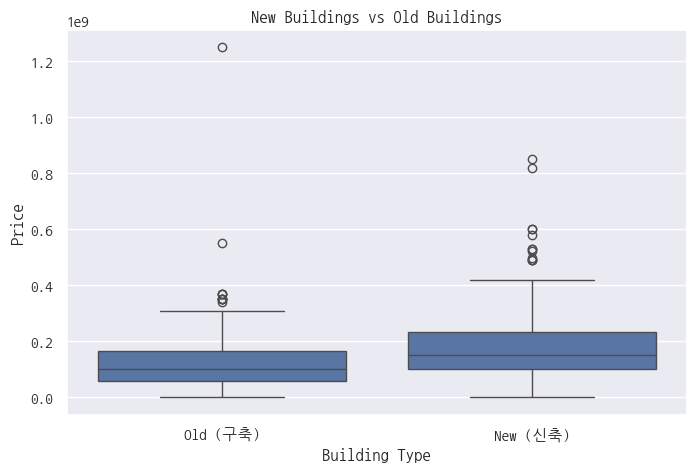

In [ ]:
# 시각화 _ boxplot 신축 vs 구축 가격 분포

import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='is_new', y='price')
plt.xticks([0, 1], ['Old (구축)', 'New (신축)'])
plt.title('New Buildings vs Old Buildings')
plt.xlabel('Building Type')
plt.ylabel('Price')
plt.show()


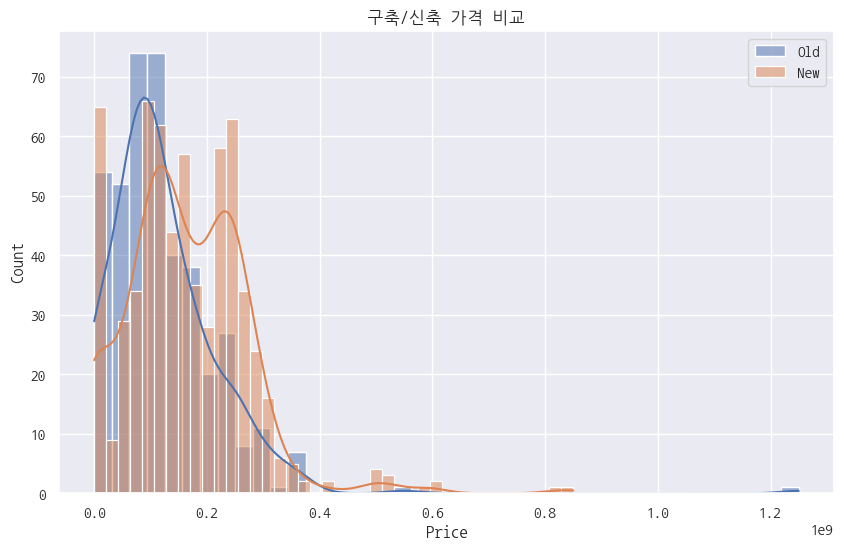

In [ ]:
# 시각화 _ 히스토그램 겹쳐서 분포 비교
plt.figure(figsize=(10, 6))

sns.histplot(df[df['is_new']==0]['price'], label='Old', kde=True, alpha=0.5, bins=40)
sns.histplot(df[df['is_new']==1]['price'], label='New', kde=True, alpha=0.5, bins=40)

plt.legend()
plt.title('구축/신축 가격 비교')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


/tmp/ipython-input-2135487110.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['is_new']==0]['price_z'], label='Old', shade=True)
/tmp/ipython-input-2135487110.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['is_new']==1]['price_z'], label='New', shade=True)


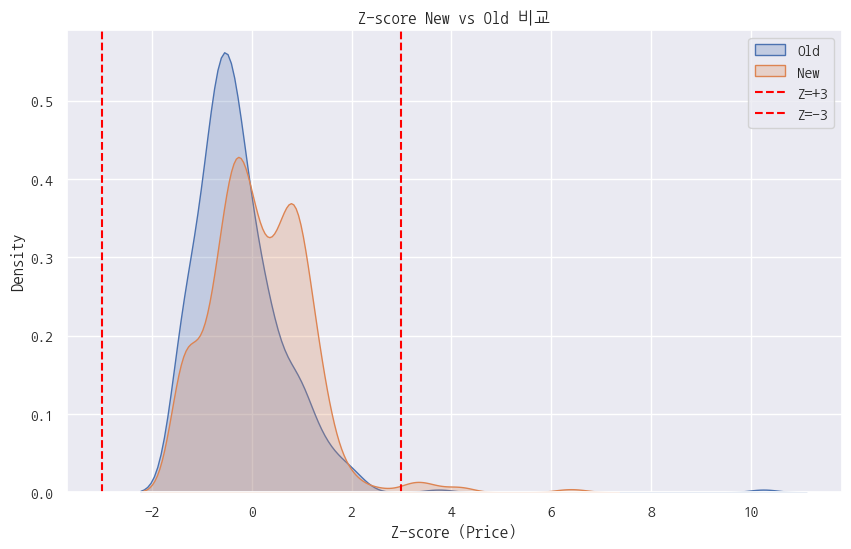

In [ ]:
#가격 Z-score 기반 이상치 분포
import numpy as np

df['price_z'] = (df['price'] - df['price'].mean()) / df['price'].std()

plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['is_new']==0]['price_z'], label='Old', shade=True)
sns.kdeplot(df[df['is_new']==1]['price_z'], label='New', shade=True)

plt.axvline(3, color='red', linestyle='--', label='Z=+3')
plt.axvline(-3, color='red', linestyle='--', label='Z=-3')

plt.title('Z-score New vs Old 비교')
plt.xlabel('Z-score (Price)')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
!pip install scikit-posthocs

In [ ]:
# 세부 가설 2
# 귀무가설(H0): 건물 유형(building_usage)에 따라 전세가격(price)은 차이가 없다.
# 대립가설(H1): 건물 유형(building_usage)에 따라 전세가격(price)은 유의미하게 다르다.

import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp
import numpy as np

# 1) building_usage 종류 확인
print(df['building_usage'].value_counts())

# 2) building_usage 그룹별 price 리스트 생성
groups = [df[df['building_usage'] == cat]['price'].dropna()
          for cat in df['building_usage'].dropna().unique()]

# 3) Kruskal-Wallis 검정
stat, p = stats.kruskal(*groups)
print("Kruskal-Wallis H-test")
print("H-statistic:", stat)
print("p-value:", p)

# pairwise Dunn test (사후검정)
dunn = sp.posthoc_dunn(df, val_col='price', group_col='building_usage', p_adjust='bonferroni')
print('사후검정',dunn)



building_usage
단독주택          476
공동주택          341
업무시설          140
제2종 근린생활시설     84
제1종 근린생활시설     12
숙박시설            4
교육연구시설          2
Name: count, dtype: int64
Kruskal-Wallis H-test
H-statistic: 320.91138678978433
p-value: 2.6919758592521136e-66
사후검정                     공동주택    교육연구시설          단독주택      숙박시설          업무시설  \
공동주택        1.000000e+00  0.180091  1.434788e-54  0.089612  6.938868e-01   
교육연구시설      1.800913e-01  1.000000  1.000000e+00  1.000000  4.304193e-01   
단독주택        1.434788e-54  1.000000  1.000000e+00  1.000000  1.178550e-19   
숙박시설        8.961250e-02  1.000000  1.000000e+00  1.000000  3.329213e-01   
업무시설        6.938868e-01  0.430419  1.178550e-19  0.332921  1.000000e+00   
제1종 근린생활시설  5.575401e-03  1.000000  1.000000e+00  1.000000  9.191178e-02   
제2종 근린생활시설  2.172934e-26  1.000000  1.000000e+00  1.000000  1.376153e-14   

            제1종 근린생활시설    제2종 근린생활시설  
공동주택          0.005575  2.172934e-26  
교육연구시설        1.000000  1.000000e+00  
단독주택          1.

In [ ]:
# 효과 크기 Kruskal-Wallis
from scipy.stats import kruskal

groups = [df[df["building_usage"] == g]["price"] for g in df["building_usage"].unique()]
k = len(groups)
n = len(df)

# Kruskal-Wallis 실행
H, p = kruskal(*groups)

# Effect size epsilon squared
epsilon_sq = (H - k + 1) / (n - k)
print("Epsilon squared:", epsilon_sq)



Epsilon squared: 0.2993454247051182


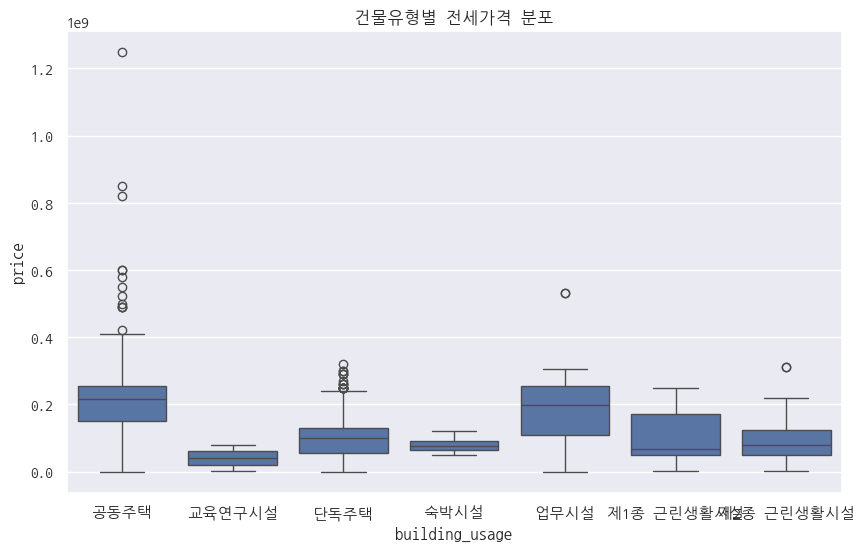

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='building_usage', y='price')
plt.title('건물유형별 전세가격 분포')
plt.show()


In [ ]:
# 이상치 점수 생성
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

df_model = df.copy()

# 결측치 처리
df_model['built_year'] = df_model['built_year'].dt.year

df_model['built_year_missing'] = df_model['built_year'].isna().astype(int)
df_model['maintenance_fee_missing'] = df_model['maintenance_fee'].isna().astype(int)
df_model['total_floor_missing'] = df_model['total_floor'].isna().astype(int)


# 결측값을 특수값으로 채움 -> Isolation Forest가 이상치로 인식하게 함
df_model['built_year'] = df_model['built_year'].fillna(0)        # 0 = 이상값
df_model['maintenance_fee'] = df_model['maintenance_fee'].fillna(-1)    # -1 = 이상값
df_model['total_floor'] = df_model['total_floor'].fillna(0)              # 0 = 이상값


# building_usage 원-핫 인코딩
df_encoded = pd.get_dummies(df_model, columns=['building_usage'], drop_first=True)


# 모델 생성
features = [
    'price', 'built_year', 'exclusive_area',
    'maintenance_fee', 'total_floor', 'is_new',
    'built_year_missing', 'maintenance_fee_missing', 'total_floor_missing'
] + [col for col in df_encoded.columns if 'building_usage_' in col]

X = df_encoded[features]

iso = IsolationForest(
    n_estimators=300,
    contamination='auto',
    random_state=42
)

iso.fit(X)

raw_score = -iso.score_samples(X)   # 음수라서 -붙여 양수화

# 0~1 정규화: build_anomaly_score
scaler = MinMaxScaler()
df['build_anomaly_score'] = scaler.fit_transform(raw_score.reshape(-1, 1))

df[['price', 'built_year', 'build_anomaly_score']].head()

df_to_save = df.drop(columns=['is_new'], errors='ignore') #분석용 컬럼 is_new 삭제
df_to_save.to_csv("daangn_list_detail_with_build_text_score.csv", index=False, encoding="utf-8-sig")


,price,built_year,build_anomaly_score
0,150000000.0,1983-07-08,0.426201
1,130000000.0,2020-03-19,0.108086
2,100000000.0,2017-11-22,0.018252
3,180000000.0,2016-12-08,0.273456
4,400000.0,2017-05-15,0.451611
